## Adjacency matrix augment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from Electrodes import Electrodes
electrodes = Electrodes()

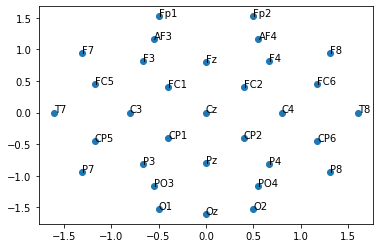

In [2]:
electrodes.plot_2d_projection()

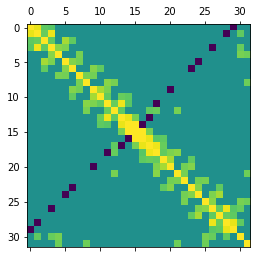

In [3]:
plt.matshow(electrodes.adjacency_matrix)

In [4]:
np.abs(electrodes.positions_3d[0]) - np.abs(electrodes.positions_3d[1])

array([ -9,   7, -21])

In [5]:
a = (electrodes.positions_3d[0] - electrodes.positions_3d[1])
print(a)
n_points = 2
b = a / (n_points + 1)
print(b)
print(electrodes.positions_3d[1] + b)
print(electrodes.positions_3d[1] + (2*b))

[  9   7 -27]
[ 3.          2.33333333 -9.        ]
[-33.          78.33333333  15.        ]
[-30.          80.66666667   6.        ]


In [6]:
electrodes.positions_3d[0],electrodes.positions_3d[1]

(array([-27,  83,  -3]), array([-36,  76,  24]))

In [7]:
def generate_in_between_positions(electrodes, num_points = 1, verbose = False):
    """
    Returns new positions in-between current electrodes with a link between them
    :param positions_3d: List of 3D electrode positional information [x,y,z]
    :param adjacency_matrix: Graph adjacency matrix. Will determine where to include the new points
    :param num_points: Number of points to include for each value in the adjacency matrix > 0
    :return: List of positions [x,y,z]
    """
    if num_points < 1:
        return electrodes.positions_3d
    # Assumes symmetric adj.matrix
    new_points = []
    for i in range(32):
        for j in range(i,32):
            a = electrodes.adjacency_matrix[i,j]
            if i != j and a != 0 and a != -1:
                if verbose:
                    print(electrodes.channel_names[i],electrodes.channel_names[j],a)
                    print(electrodes.positions_3d[i], electrodes.positions_3d[j])
                inc = (electrodes.positions_3d[i] - electrodes.positions_3d[j])
                inc_step = inc / (num_points + 1)
                for n in range(1,num_points+1):
                    new_point = electrodes.positions_3d[j] + (n*inc_step)
                    if verbose:
                        print(new_point)
                    new_points.append(new_point)
    return np.vstack([electrodes.positions_3d, np.array(new_points)])

In [22]:
%matplotlib notebook
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_electrodes_3d(electrodes, pos_3d, plot_links = False):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d',azim=-40,elev=20)

    x,y,z = pos_3d.T[0],pos_3d.T[1],pos_3d.T[2]
    # Plot points
    ax.scatter(x,y,z,marker='o',c=z)
    # Plot lines to XY plane and node labels
    for i, (x,y,z) in enumerate(zip(x,y,z)):
        if i < 32: 
            ax.text(x, y, z, electrodes.channel_names[i], color='black')
        ax.plot([x, x], [y,y],':',zs=[z,0],alpha=0.15)
    # Draw link between nodes with weight = link weight
    adj_matrix = electrodes.get_adjacency_matrix(add_global_connections=True, positions_3d=pos_3d)
    for i in range(0,adj_matrix.shape[0]):
        for j in range(0,adj_matrix.shape[0]):
            # Local connections
            if i is not j and adj_matrix[i][j] > 0:
                x1,y1,z1 = pos_3d.T[0][i],pos_3d.T[1][i],pos_3d.T[2][i]
                x2,y2,z2 = pos_3d.T[0][j],pos_3d.T[1][j],pos_3d.T[2][j]
                ax.plot([x1, x2], [y1,y2],'--',zs=[z1,z2],alpha=adj_matrix[i][j],color='#ff00ff')
            # Global connections
            elif i is not j and adj_matrix[i][j] < 0:
                x1,y1,z1 = electrodes.positions_3d.T[0][i],electrodes.positions_3d.T[1][i],electrodes.positions_3d.T[2][i]
                x2,y2,z2 = electrodes.positions_3d.T[0][j],electrodes.positions_3d.T[1][j],electrodes.positions_3d.T[2][j]
                ax.plot([x1, x2], [y1,y2],'--',zs=[z1,z2],alpha=abs(adj_matrix[i][j])*0.5,color='blue')


    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

<IPython.core.display.Javascript object>


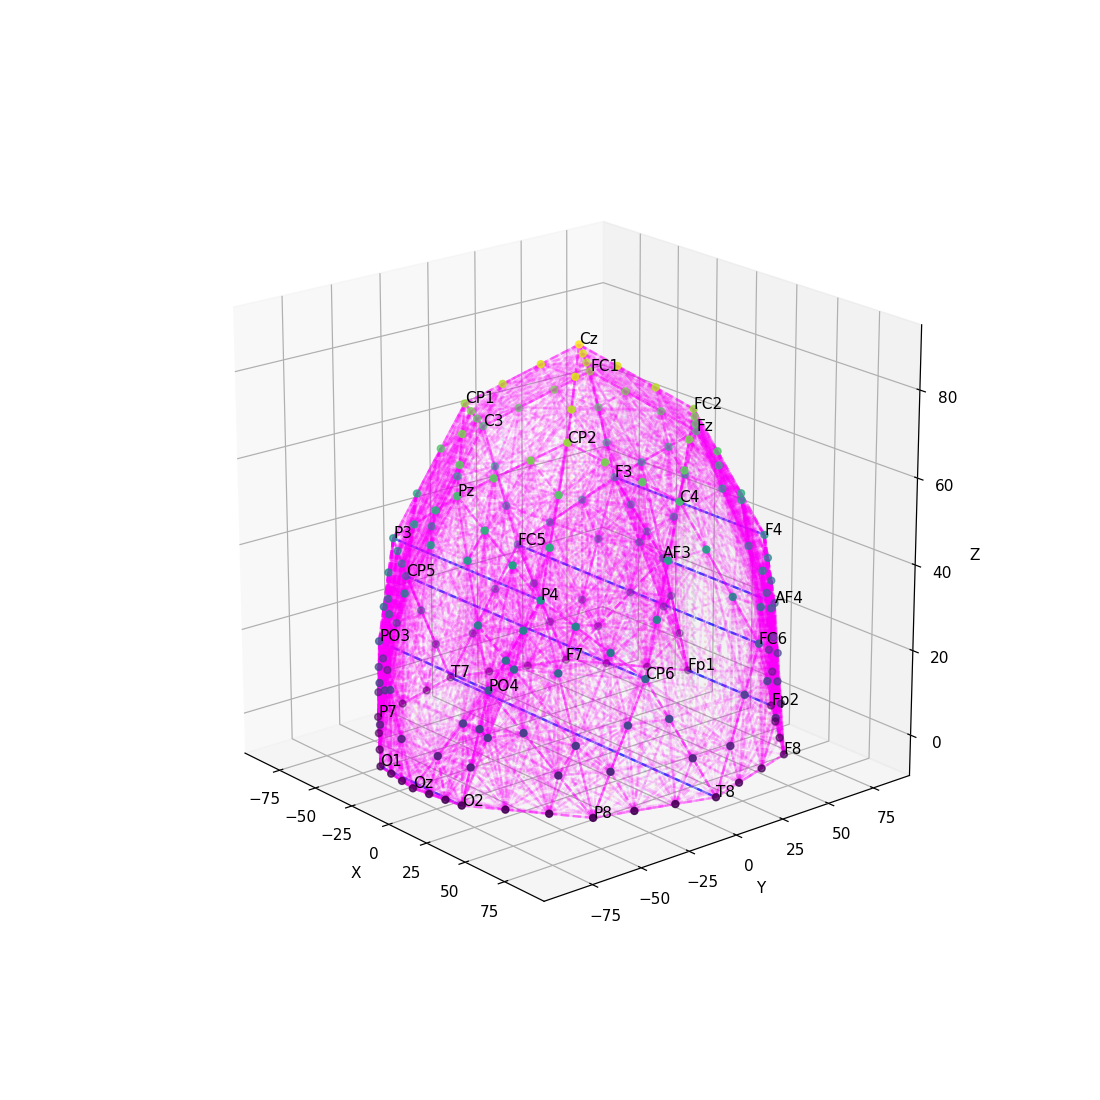

In [26]:
plot_electrodes_3d(electrodes,generate_in_between_positions(electrodes,2))

<IPython.core.display.Javascript object>


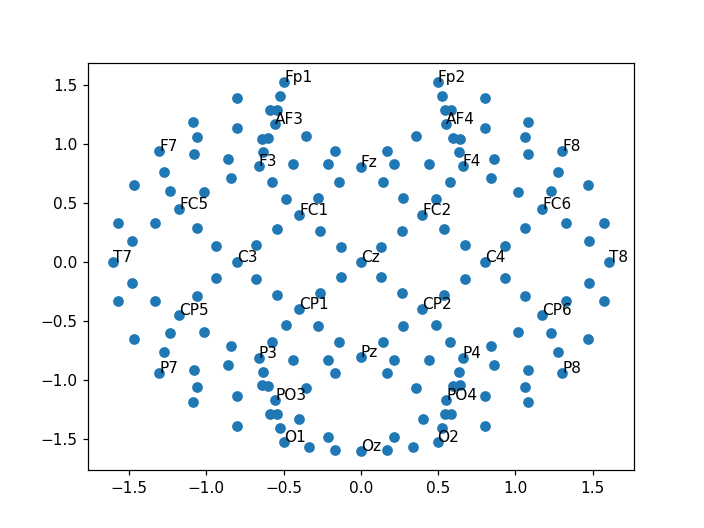

In [10]:
new_pos_3d = generate_in_between_positions(electrodes,2)
new_pos_2d = electrodes.get_proyected_2d_positions(new_pos_3d)
electrodes.plot_2d_projection(new_pos_2d)

<IPython.core.display.Javascript object>


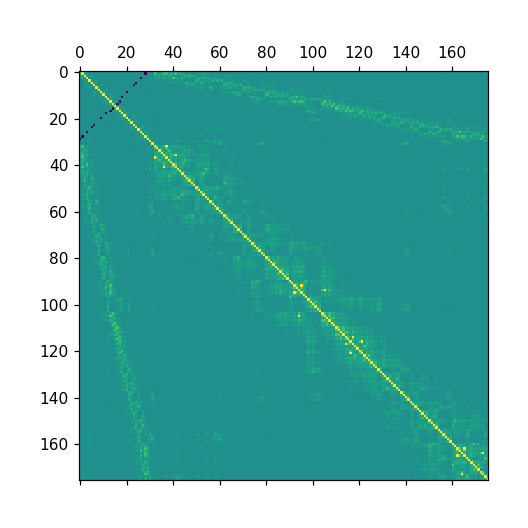

In [11]:
new_adj_mat = electrodes.get_adjacency_matrix(add_global_connections=True, positions_3d=new_pos_3d)
plt.matshow(new_adj_mat)

## Feature matrix augment

In [36]:
import os
import scipy.io
from einops import reduce
# Constants used to define data paths
ROOT_DIR = './'
RAW_DIR = 'data/matlabPREPROCESSED'
PROCESSED_DIR = 'data/graphProcessedData'

In [34]:
raw_file_names = os.listdir(RAW_DIR)
raw_file_names.sort()
all_subjects = [scipy.io.loadmat(f'{RAW_DIR}/{name}') for name in raw_file_names]

In [37]:
all_data = [subject['data'] for subject in all_subjects]
all_labels = [subject['labels'] for subject in all_subjects]
labels = np.stack(all_labels)
all_labels = reduce(labels,'s v c -> (s v) c','mean')
data = np.stack(all_data)
all_data = reduce(data,'s v c d -> (s v) c d','mean')

In [50]:
import scipy.interpolate
points = electrodes.positions_3d
values = all_data[0,:32]
interpolated_values = scipy.interpolate.griddata(points, values, new_pos_3d, method='linear')

<IPython.core.display.Javascript object>


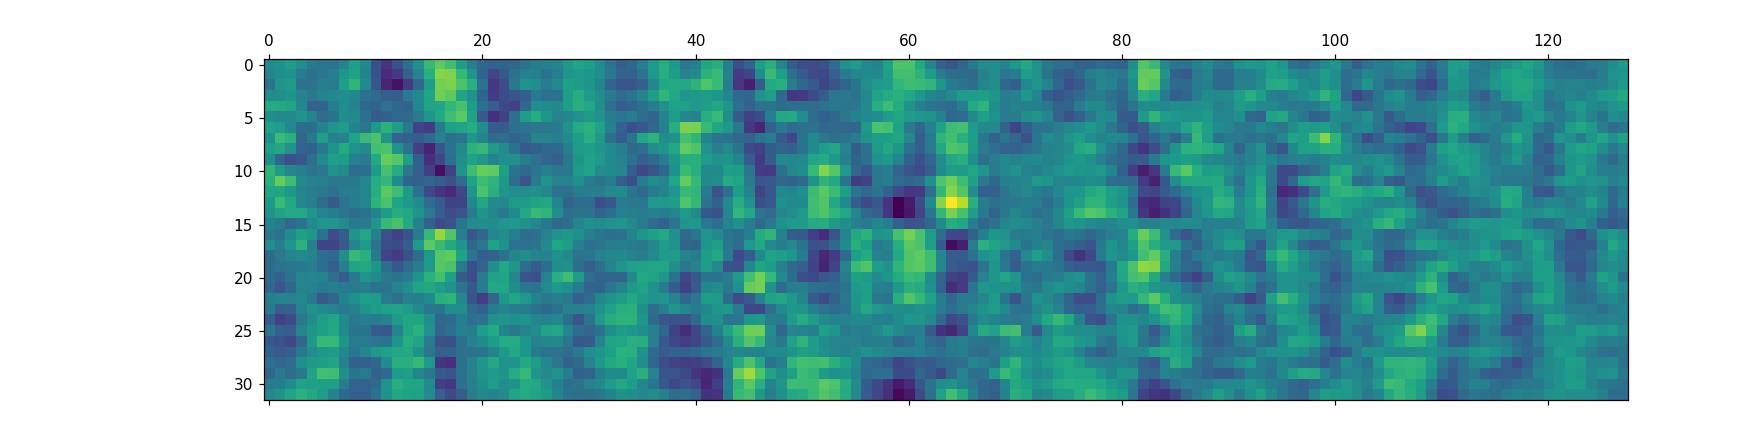

In [49]:
plt.matshow((all_data[0][:32,0:128]))

<IPython.core.display.Javascript object>


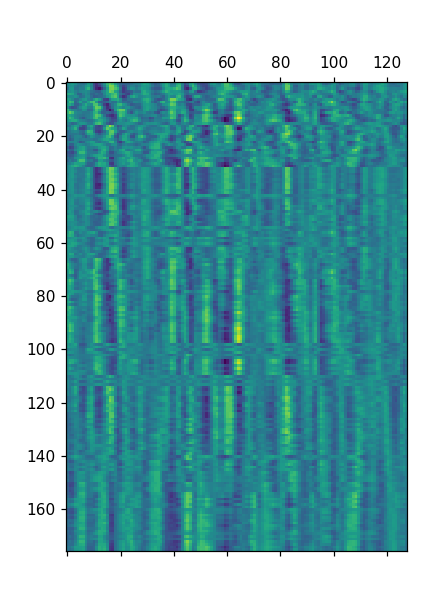

In [51]:
plt.matshow(interpolated_values[:,:128])